In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import feather
import json
import os
import glob
import time
import datetime
from caerus import caerus
from findpeaks import findpeaks
from datetime import datetime
import matplotlib.pyplot as plt
import mplfinance as mpf
import matplotlib.image as mpimg

### We applied additional manual filtering on top of the previous filtering actionis, that was by peak detection and clustering

let's scrap that images' names:

In [2]:
# visually and manually selected folders and graphs of the desired clusters
all_imgs = []
parent_dir = 'C:/Users/Kuanysh/Downloads/pump_and_dump/new_clusters_4'
folders = glob.glob(parent_dir + '/*')
for folder in folders: # in 186 folders:
    #print(folder)
    imgs = glob.glob(folder + '/*')
    all_imgs.extend(imgs)

out of 16356 samples, we have filtered:

In [3]:
len(all_imgs)

9567

In [4]:
# create a list based on the filtered pumps and dumps' images:
new_list = []
for item in all_imgs:
    new_item = item.split("\\")[2].split(".")[0].split(" ")
    new_list.append(new_item)

In [14]:
new_list[:5]

[['ADMP', '2021-05-25'],
 ['ADXS', '2020-01-30'],
 ['ALNA', '2021-07-28'],
 ['AMC', '2020-04-29'],
 ['BIGC', '2020-08-25']]

### Here we tried to divide pumps by their duration, its easier to distinguish pump from not-pump observation in one duration group:

In [1]:
def find_dur(new_list):
    abs_new_list = []
    not_in_list = []
    for i in tqdm(range(len(new_list))):
        
        # let's find out our quotes by file name:
        ticker_name = new_list[i][0]
        day = new_list[i][1]
        parent_dir_min = 'C:/Users/Kuanysh/Downloads/pump_and_dump/agg_tickers_1m_feather'
        file_min = os.path.join(parent_dir_min, ticker_name + '.feather')
        df_min = pd.read_feather(file_min)
        
        #let's take into account that intraday rows don't go minute by minute,
        # therefore we need to link every row with its corresponing minute during 960 minutes of the trading day
        df_min.dropna(axis=0, how='all', inplace=True)
        df_min['datetime'] = pd.to_datetime(df_min.date.astype(str) + ' ' + df_min.time.astype(str))
        df1 = df_min[df_min['date']==day]
        number_of_prints = len(df1)
        df1.set_index('datetime', inplace=True)
        start_time = pd.to_datetime(day + ' ' + "04:01")
        end_time = pd.to_datetime(day + ' ' + "20:00")
        index=pd.date_range(start_time, end_time, freq="1min")
        columns = ['A']
        data = np.array([np.arange(960)]).T
        df2 = pd.DataFrame(data,index=index, columns=columns)
        concat_df = pd.concat([df2, df1], axis=1)
        open_price = concat_df.open.fillna(method='ffill').to_numpy()
        
        # then let's use the caerus method for signal and peak detection:
        fp = findpeaks(method='caerus', params_caerus={'minperc':7, 'window':20}) 
        # params_caerus={'minperc':7, 'window':30}) for 'not_in_list' list
        results = fp.fit(open_price)
        df = results['df']
        y_peaks = pd.concat([df['y'], df['y'].loc[df['peak']]], axis=1).iloc[:,1]
        y_valleys = pd.concat([df['y'], df['y'].loc[df['valley']]], axis=1).iloc[:,1]
        real_peaks = y_peaks[y_peaks>0]
        real_valleys = y_valleys[y_valleys>0]
        
        # now we need to collect durations (using their locations) and returns (using their values)
        # for the first and second peaks and valleys (for double-tops list)
        
        if 0<real_peaks.size<2 and 0<real_valleys.size<2: # the case when there are only one peak and one valley:
            dur1 = real_peaks.index[0]-real_valleys.index[0]
            dur2 = 200
            if real_peaks.index[0]>real_valleys.index[0]:
                peak_ret1 = round(real_peaks.iloc[0]/real_valleys.iloc[0]-1, 4)
                peak_ret2 = 0
            else:
                peak_ret1 = 0
                peak_ret2 = 0
            abs_new_list.append([ticker_name, day, dur1, dur2, peak_ret1, peak_ret2, real_peaks.index[0], -100, number_of_prints])
            np.save('abs_new_list_.npy', abs_new_list)
        
        elif real_peaks.size>1 and real_valleys.size>1: # the case when there are several peak and valleys:
            dur1 = real_peaks.index[0]-real_valleys.index[0]
            dur2 = real_peaks.index[1]-real_valleys.index[1]
            if real_peaks.index[0]>real_valleys.index[0]:
                peak_ret1 = round(real_peaks.iloc[0]/real_valleys.iloc[0]-1, 4)
            else:
                peak_ret1 = 0 
            if real_peaks.index[1]>real_valleys.index[1]:
                peak_ret2 = round(real_peaks.iloc[1]/real_valleys.iloc[1]-1, 4)
            else:
                peak_ret2 = 0
            abs_new_list.append([ticker_name, day, dur1, dur2, peak_ret1, peak_ret2, real_peaks.index[0], real_peaks.index[1], number_of_prints])
            np.save('abs_new_list_.npy', abs_new_list)
        
        else: # otherwise the caerus just didn't process them:
            not_in_list.append([ticker_name, day])
            np.save('not_in_list_.npy', not_in_list)

    return abs_new_list, not_in_list

In [7]:
abs_new_list_tot, not_in_list_tot = find_dur(new_list)

In [97]:
#np.save('abs_new_list_tot.npy', abs_new_list_tot)
#np.save('not_in_list_tot.npy', not_in_list_tot)

In [9]:
abs_new_list_tot = np.load('abs_new_list_tot.npy')
not_in_list_tot = np.load('not_in_list_tot.npy')

In [11]:
len(abs_new_list_tot), len(not_in_list_tot)

(9470, 97)

In [13]:
df_dur = pd.DataFrame(abs_new_list_tot, columns=['ticker', 'day', 'dur1', 'dur2', 'return1', 
                                                 'return2', 'peak_idx1', 'peak_idx2', 'number_of_prints'])
for col in ['return1', 'return2']:
    df_dur[col] = df_dur[col].astype(float)
    
for col in ['dur1', 'dur2', 'peak_idx1', 'peak_idx2', 'number_of_prints']:
    df_dur[col] = df_dur[col].astype(int)
    
df_dur

,ticker,day,dur1,dur2,return1,return2,peak_idx1,peak_idx2,number_of_prints
0,ADMP,2021-05-25,14,20,0.1283,0.0893,20,213,658
1,ADXS,2020-01-30,29,22,0.2710,0.1027,340,598,580
2,ALNA,2021-07-28,12,200,0.1309,0.0000,390,-100,600
3,AMC,2020-04-29,18,4,0.1344,0.2181,199,334,706
4,BIGC,2020-08-25,38,11,0.3336,0.0932,458,491,608
...,...,...,...,...,...,...,...,...,...
9465,UXIN,2020-10-07,27,22,0.0845,0.1600,376,801,431
9466,WEI,2020-10-20,47,58,1.7630,2.3829,379,457,451
9467,WEI,2021-07-06,20,27,0.0896,0.1729,590,612,509
9468,WKEY,2020-08-06,23,200,0.2022,0.0000,627,-100,348


In [21]:
#df_dur.to_csv('df_dur2.csv')

First pumps, i.e. that appeared first during the day:

In [ ]:
# params:
sharp1 = df_dur[(df_dur['dur1']>=0) & (df_dur['dur1']<=5)].sort_values(by=['dur1', 'return1'], ascending=[True, False])
midsharp1 = df_dur[(df_dur['dur1']>5) & (df_dur['dur1']<=10)].sort_values(by=['dur1', 'return1'], ascending=[True, False])
moderate1 = df_dur[(df_dur['dur1']>10) & (df_dur['dur1']<=15)].sort_values(by=['dur1', 'return1'], ascending=[True, False])
slow1 = df_dur[(df_dur['dur1']>15) & (df_dur['dur1']<=20)].sort_values(by=['dur1', 'return1'], ascending=[True, False])
sluggish1 = df_dur[(df_dur['dur1']>20) & (df_dur['dur1']<=25)].sort_values(by=['dur1', 'return1'], ascending=[True, False])
letargic1 = df_dur[(df_dur['dur1']>25) & (df_dur['dur1']<=30)].sort_values(by=['dur1', 'return1'], ascending=[True, False])
dilatory1 = df_dur[(df_dur['dur1']>30) & (df_dur['dur1']<=35)].sort_values(by=['dur1', 'return1'], ascending=[True, False])

# data:
sharp_dumps1 = sharp1[['ticker', 'day', 'return1', 'peak_idx1', 'dur1', 'number_of_prints']].to_numpy().tolist()
midsharp_dumps1 = midsharp1[['ticker', 'day', 'return1', 'peak_idx1', 'dur1', 'number_of_prints']].to_numpy().tolist()
moderate_dumps1 = moderate1[['ticker', 'day', 'return1', 'peak_idx1', 'dur1', 'number_of_prints']].to_numpy().tolist()
slow_dumps1 = slow1[['ticker', 'day', 'return1', 'peak_idx1', 'dur1', 'number_of_prints']].to_numpy().tolist()
sluggish_dumps1 = sluggish1[['ticker', 'day', 'return1', 'peak_idx1', 'dur1', 'number_of_prints']].to_numpy().tolist()
letargic_dumps1 = letargic1[['ticker', 'day', 'return1', 'peak_idx1', 'dur1', 'number_of_prints']].to_numpy().tolist()
dilatory_dumps1 = dilatory1[['ticker', 'day', 'return1', 'peak_idx1', 'dur1', 'number_of_prints']].to_numpy().tolist()

Second pumps that occured after the first ones, sometimes we get the same sample:

In [ ]:
# params:
sharp2 = df_dur[(df_dur['dur2']>=0) & (df_dur['dur2']<=5)].sort_values(by=['dur2', 'return2'], ascending=[True, False])
midsharp2 = df_dur[(df_dur['dur2']>5) & (df_dur['dur2']<=10)].sort_values(by=['dur2', 'return2'], ascending=[True, False])
moderate2 = df_dur[(df_dur['dur2']>10) & (df_dur['dur2']<=15)].sort_values(by=['dur2', 'return2'], ascending=[True, False])
slow2 = df_dur[(df_dur['dur2']>15) & (df_dur['dur2']<=20)].sort_values(by=['dur2', 'return2'], ascending=[True, False])
sluggish2 = df_dur[(df_dur['dur2']>20) & (df_dur['dur2']<=25)].sort_values(by=['dur2', 'return2'], ascending=[True, False])
letargic2 = df_dur[(df_dur['dur2']>25) & (df_dur['dur2']<=30)].sort_values(by=['dur2', 'return2'], ascending=[True, False])
dilatory2 = df_dur[(df_dur['dur2']>30) & (df_dur['dur2']<=35)].sort_values(by=['dur2', 'return2'], ascending=[True, False])

# data:
sharp_dumps2 = sharp2[['ticker', 'day', 'return2', 'peak_idx2', 'dur2', 'number_of_prints']].to_numpy().tolist()
midsharp_dumps2 = midsharp2[['ticker', 'day', 'return2', 'peak_idx2', 'dur2', 'number_of_prints']].to_numpy().tolist()
moderate_dumps2 = moderate2[['ticker', 'day', 'return2', 'peak_idx2', 'dur2', 'number_of_prints']].to_numpy().tolist()
slow_dumps2 = slow2[['ticker', 'day', 'return2', 'peak_idx2', 'dur2', 'number_of_prints']].to_numpy().tolist()
sluggish_dumps2 = sluggish2[['ticker', 'day', 'return2', 'peak_idx2', 'dur2', 'number_of_prints']].to_numpy().tolist()
letargic_dumps2 = letargic2[['ticker', 'day', 'return2', 'peak_idx2', 'dur2', 'number_of_prints']].to_numpy().tolist()
dilatory_dumps2 = dilatory2[['ticker', 'day', 'return2', 'peak_idx2', 'dur2', 'number_of_prints']].to_numpy().tolist()

In [ ]:
#np.save('sharp_dumps1.npy', sharp_dumps1)
#np.save('sharp_dumps2.npy', sharp_dumps2)

#np.save('midsharp_dumps1.npy', midsharp_dumps1)
#np.save('midsharp_dumps2.npy', midsharp_dumps2)

#np.save('moderate_dumps1.npy', moderate_dumps1)
#np.save('moderate_dumps2.npy', moderate_dumps2)

#np.save('slow_dumps1.npy', slow_dumps1)
#np.save('slow_dumps2.npy', slow_dumps2)

#np.save('sluggish_dumps1.npy', sluggish_dumps1)
#np.save('sluggish_dumps2.npy', sluggish_dumps2)

#np.save('letargic_dumps1.npy', letargic_dumps1)
#np.save('letargic_dumps2.npy', letargic_dumps2)

#np.save('dilatory_dumps1.npy', dilatory_dumps1)
#np.save('dilatory_dumps2.npy', dilatory_dumps2)

### The code below plots a collage of pumps and dumps in 3 different timeframes like this:

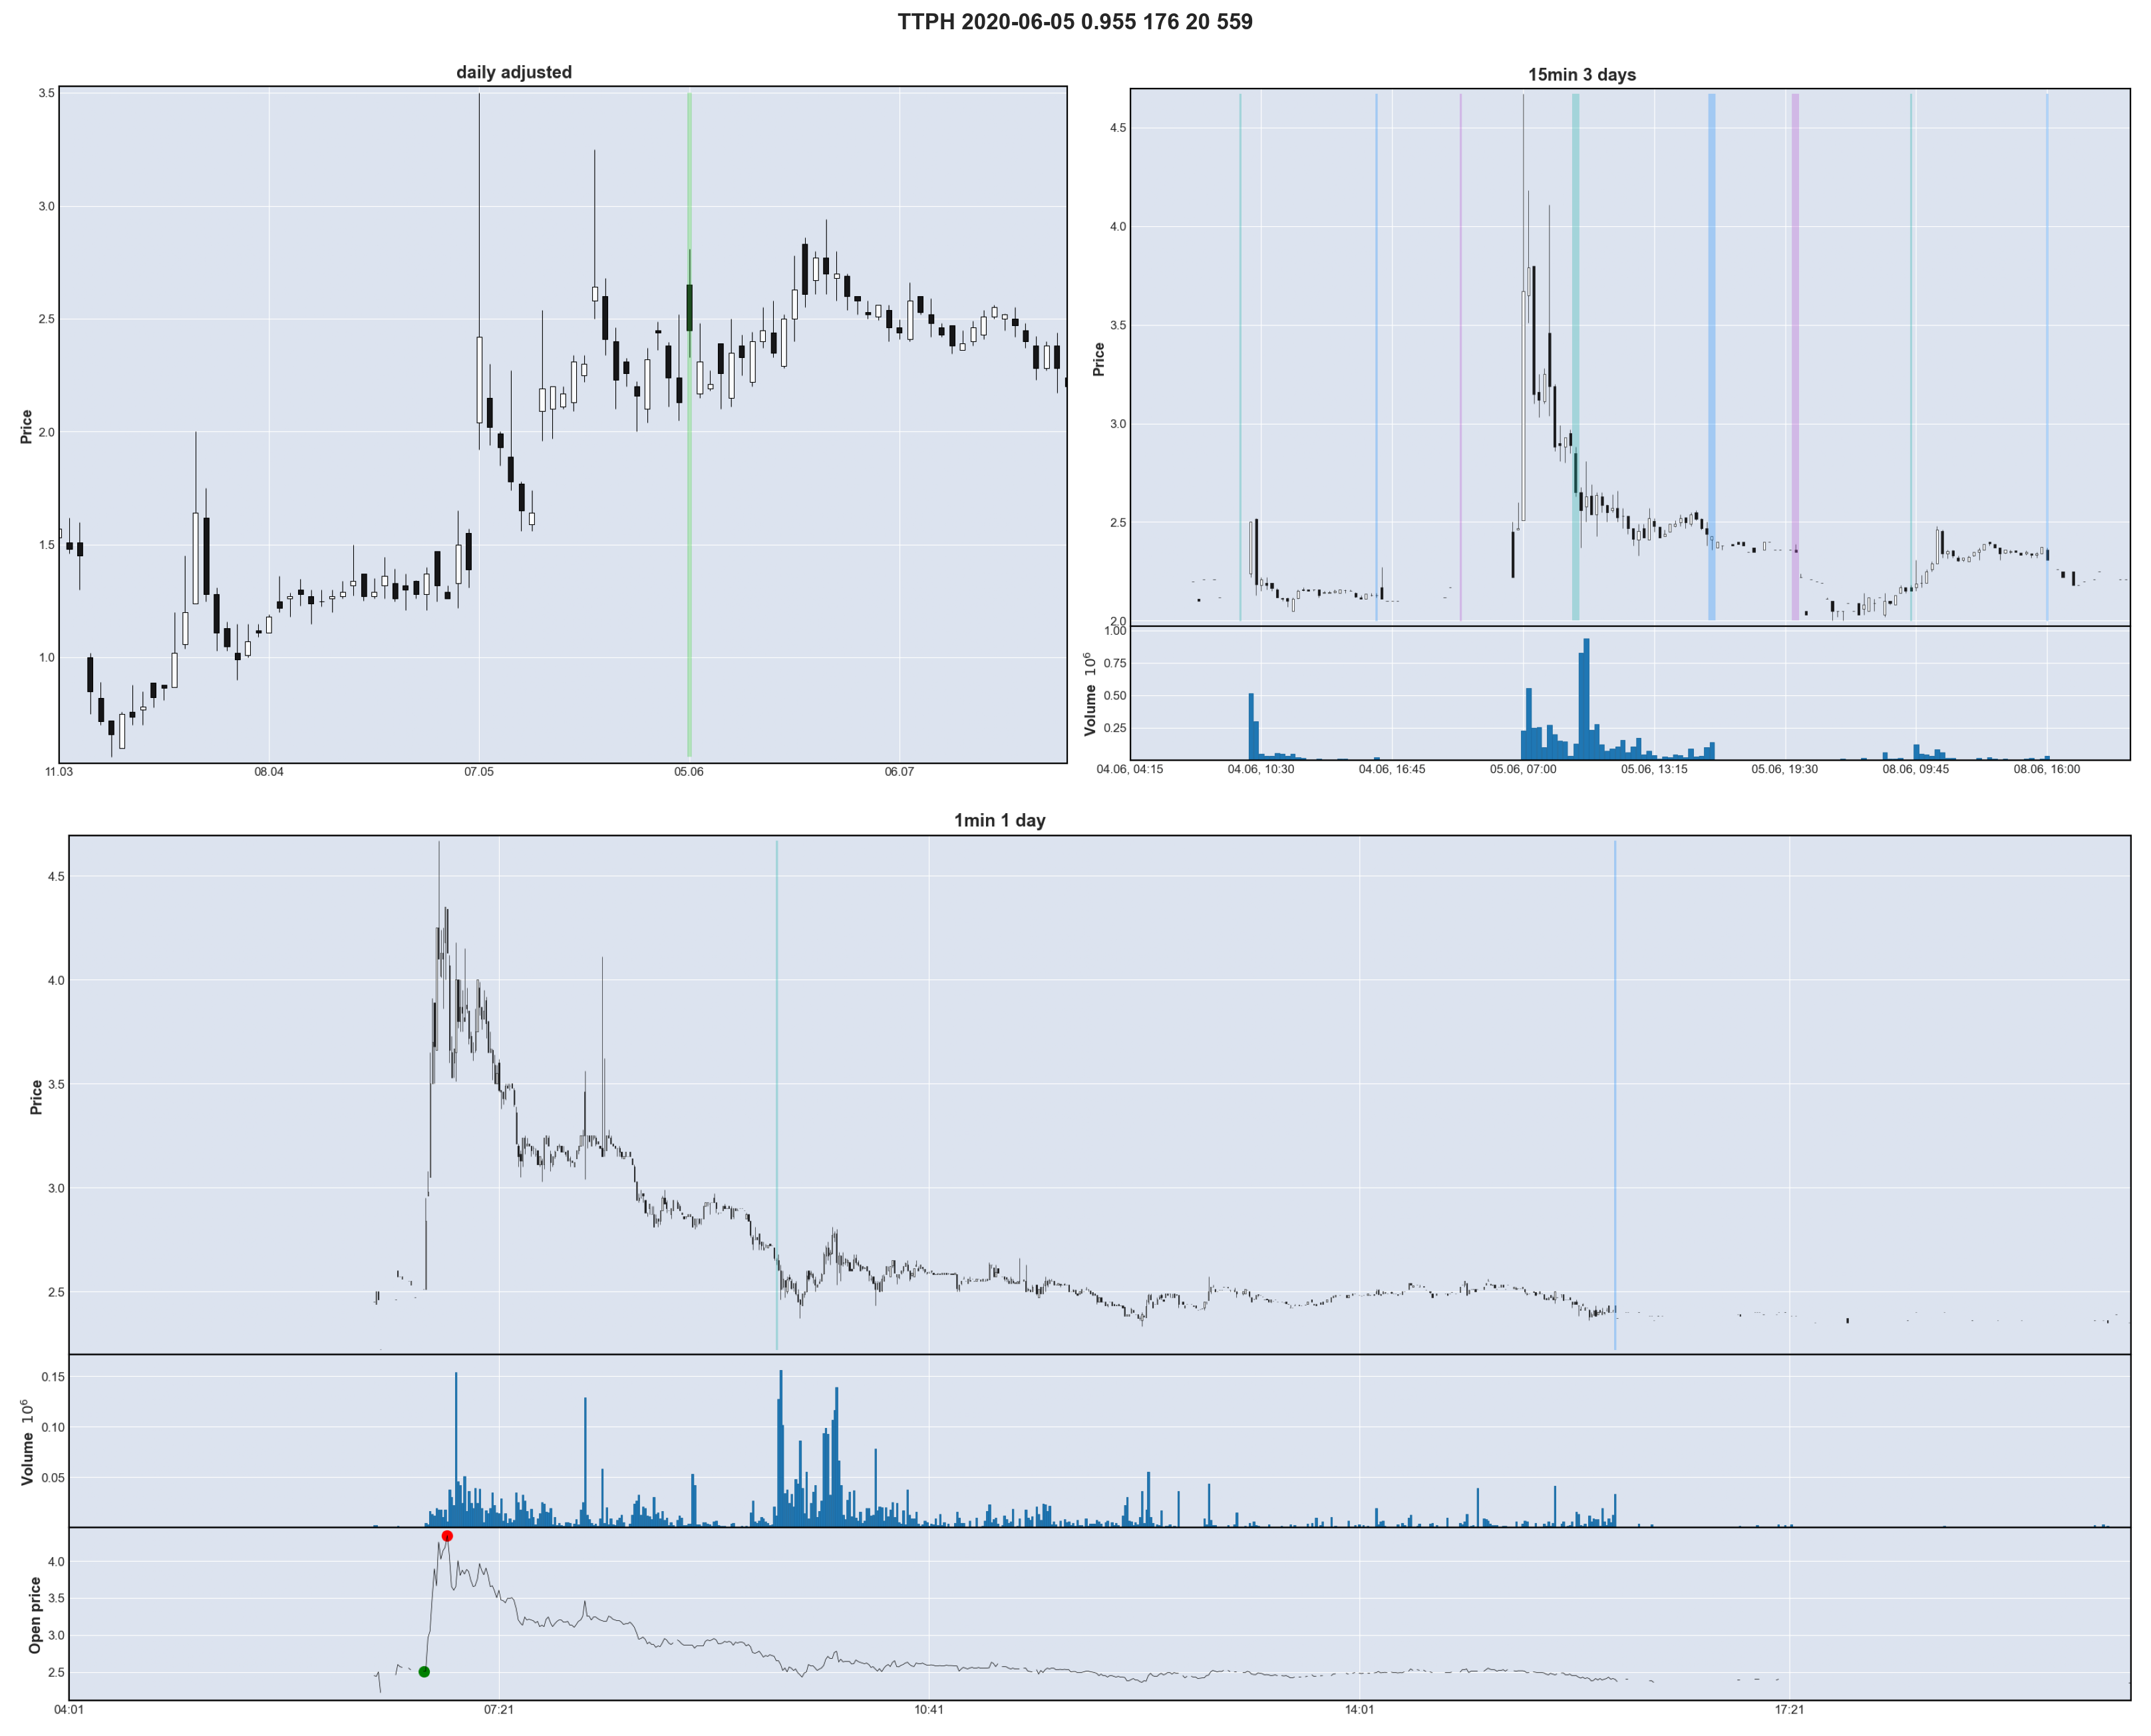

In [16]:
from IPython.display import Image
Image('TTPH 2020-06-05.png')

In [12]:
### Daily adj
def plot_daily(ticker_name, day):
    parent_dir = 'C:/Users/Kuanysh/Downloads/pump_and_dump/all_tickers_daily_adj_feather'
    file = os.path.join(parent_dir, ticker_name + '.feather')
    df = pd.read_feather(file)
    df.dropna(axis=0, how='all', inplace=True)
    df.sort_values(by='date', ascending=True, inplace=True)
    df.set_index('date', inplace=True)
    if day in df.index:
        locs = df.index.get_loc(pd.to_datetime(day))
        a = locs-60
        b = locs+40
        h = len(df.index)
        if a<=0:
            if b>=h:
                df = df.iloc[0:h,:]
        else:
            if b>=h:
                df = df.iloc[a:h,:]
            else:
                df = df.iloc[a:b,:]
        pictures_dir = 'C:/Users/Kuanysh/Downloads/pump_and_dump/laggard_dumps'
        file1 = os.path.join(pictures_dir, ticker_name + '_' + day + '_' + 'dailyadj' + '.png')

        xlim = (df.index[0], df.index[-1])
        mpf.plot(df, figsize =(1600/100,1200/100), type='candle', volume=False, \
                 vlines=dict(vlines=day, colors='limegreen', \
                 linewidths=3, alpha=0.3), \
                 warn_too_much_data=1000, title='daily adjusted', \
                 tight_layout=True, scale_padding={'left': 1, 'top': 4, 'right': 1, 'bottom': 1}, \
                 scale_width_adjustment=dict(candle=1.0),show_nontrading=False, xlim=xlim, \
                 xrotation=0, datetime_format='%d.%m', savefig=file1)
    else:
        file1=0
    
    return file1

In [13]:
### 15min
def plot_15min(ticker_name, day):
    parent_dir = 'C:/Users/Kuanysh/Downloads/pump_and_dump/agg_tickers_15m_feather'
    file = os.path.join(parent_dir, ticker_name + '.feather')
    df = pd.read_feather(file)
    df.dropna(axis=0, how='all', inplace=True)
    df_grouped = df.groupby(df['date']).count()
    locs = df_grouped.index.get_loc(pd.to_datetime(day))
    prev_day = df_grouped.index[locs-1].date()
    next_day = df_grouped.index[locs+1].date()
    
    days = [str(prev_day), day, str(next_day)]
    df['datetime'] = pd.to_datetime(df.date.astype(str) + ' ' + df.time.astype(str))

    concat_dfs = pd.DataFrame()
    for day_k in days:
        df1 = df[df['date']==day_k]
        df1.set_index('datetime', inplace=True)
    
        start_time = pd.to_datetime(day_k + ' ' + "04:15")
        end_time = pd.to_datetime(day_k + ' ' + "20:00")
        index=pd.date_range(start_time, end_time, freq="15min")
        columns = ['A']
        data = np.array([np.arange(64)]).T
        df2 = pd.DataFrame(data, index=index, columns=columns)
        concat_df = pd.concat([df2, df1], axis=1)
        concat_dfs = concat_dfs.append(concat_df)
    
    xlim = (concat_dfs.index[0], concat_dfs.index[-1])
    vls = [str(prev_day)+' '+'09:30:00', str(prev_day)+' '+'16:00:00', str(prev_day)+' '+'20:00:00',
    day+' '+'09:30:00', day+' '+'16:00:00', day+' '+'20:00:00',
    str(next_day)+' '+'09:30:00', str(next_day)+' '+'16:00:00', str(next_day)+' '+'20:00:00']
    pictures_dir = 'C:/Users/Kuanysh/Downloads/pump_and_dump/laggard_dumps'
    file2 = os.path.join(pictures_dir, ticker_name + '_' + day + '_' + '15min' + '.png')

    mpf.plot(concat_dfs.iloc[:,3:], panel_ratios=(4, 1), figsize =(1600/100,1200/100), type='candle', volume=True, \
             vlines=dict(vlines=vls, colors=('lightseagreen', 'dodgerblue', 'mediumorchid'), \
             linewidths=(1,1,1,6,6,6,1,1,1), alpha=0.3), \
             warn_too_much_data=1000, title='15min 3 days', \
             tight_layout=True, scale_padding={'left': 1, 'top': 4, 'right': 1, 'bottom': 1}, \
             scale_width_adjustment=dict(candle=1.0),show_nontrading=False, xlim=xlim, \
             xrotation=0, datetime_format='%d.%m, %H:%M', volume_exponent=6, savefig=file2)
    
    return file2

In [14]:
### 1min
def plot_1min(ticker_name, day):

    parent_dir_min = 'C:/Users/Kuanysh/Downloads/pump_and_dump/agg_tickers_1m_feather'
    file_min = os.path.join(parent_dir_min, ticker_name + '.feather')
    df_min = pd.read_feather(file_min)
    df_min.dropna(axis=0, how='all', inplace=True)
    df_min['datetime'] = pd.to_datetime(df_min.date.astype(str) + ' ' + df_min.time.astype(str))

    df1 = df_min[df_min['date']==day]
    df1.set_index('datetime', inplace=True)

    start_time = pd.to_datetime(day + ' ' + "04:01")
    end_time = pd.to_datetime(day + ' ' + "20:00")
    index=pd.date_range(start_time, end_time, freq="1min")
    columns = ['A']
    data = np.array([np.arange(960)]).T
    df2 = pd.DataFrame(data,index=index, columns=columns)
    concat_df = pd.concat([df2, df1], axis=1)

    xlim = (concat_df.index[0], concat_df.index[-1])
    vls = [day+' '+'09:30:00', day+' '+'16:00:00']

    open_price = concat_df.open.fillna(method='ffill').to_numpy()
    fp = findpeaks(method='caerus', params_caerus={'minperc':7, 'window':20})
    results = fp.fit(open_price)
    df = results['df']
    y_peaks = pd.concat([df['y'], df['y'].loc[df['peak']]], axis=1).iloc[:,1]
    y_valleys = pd.concat([df['y'], df['y'].loc[df['valley']]], axis=1).iloc[:,1]
    if y_peaks[y_peaks>0].size!=0:
        peak_at = y_peaks[y_peaks>0].index[0]
        apds = [mpf.make_addplot(df['y'], panel=2, type='line', ylabel='Open price', color='k', width=0.5),
                mpf.make_addplot(y_peaks, panel=2, type='scatter', color='r', markersize=100, marker='o'),
                mpf.make_addplot(y_valleys, panel=2, type='scatter', color='g', markersize=100, marker='o'),
               ]
        pictures_dir = 'C:/Users/Kuanysh/Downloads/pump_and_dump/laggard_dumps'
        file3 = os.path.join(pictures_dir, ticker_name + '_' + day + '_' + '1min' + '.png')

        mpf.plot(concat_df.iloc[:,3:], addplot=apds, panel_ratios=(3, 1, 1), figsize =(3200/100,1500/100), type='candle', volume=True, \
                 vlines=dict(vlines=vls, colors=('lightseagreen', 'dodgerblue'), \
                 linewidths=1, alpha=0.3), \
                 warn_too_much_data=1000, title='1min 1 day', \
                 tight_layout=True, scale_padding={'left': 1, 'top': 4, 'right': 1, 'bottom': 1}, \
                 scale_width_adjustment=dict(candle=1.0),show_nontrading=False, xlim=xlim, \
                 xrotation=0, datetime_format='%H:%M',volume_exponent=6, savefig=file3)
    else:
        file3 = 0
        peak_at = 2000
    
    return file3, peak_at

In [15]:
def plot_collage(file1, file2, file3, ticker_name, day, day_return, peak_at, dist, number_of_prints):
    fig = plt.figure(figsize=(32, 27))

    fig.suptitle(ticker_name+' '+day+' '+str(day_return)+' '+str(peak_at)+' '+str(dist)+' '+str(number_of_prints), fontsize=24, y=0.95, va='center')
    fig.subplots_adjust(bottom = 0., left = 0, top = 1.12, right = 1.12)

    sub1 = fig.add_subplot(2,2,1) 
    sub1.imshow(mpimg.imread(file1)), sub1.axis('off')

    sub2 = fig.add_subplot(2,2,2) 
    sub2.imshow(mpimg.imread(file2)), sub2.axis('off')

    sub3 = fig.add_subplot(2,2,(3,4))
    sub3.imshow(mpimg.imread(file3)), sub3.axis('off')

    fig.tight_layout(pad=0.2, w_pad=0.2, h_pad=0.2)
    
    pictures_dir = 'C:/Users/Kuanysh/Downloads/pump_and_dump/laggard_dumps'
    file = os.path.join(pictures_dir, ticker_name + ' ' + day +'.png')
    fig.savefig(file, bbox_inches='tight', pad_inches=0.2) # 
    os.remove(file1)
    os.remove(file2)
    os.remove(file3)
    plt.close(fig)

In [16]:
no_daily_figs1 = []
errors_list1 = []

clust_imgs_arr = laggard_dumps2
for i in tqdm(range(len(clust_imgs_arr))):
    ticker_name = clust_imgs_arr[i][0]
    day = clust_imgs_arr[i][1]
    day_return = clust_imgs_arr[i][2]
    peak_at = clust_imgs_arr[i][3]
    dist = clust_imgs_arr[i][4]
    number_of_prints = clust_imgs_arr[i][5]
    
    file1 = plot_daily(ticker_name, day)
    if file1==0:
        no_daily_figs1.append([ticker_name, day, day_return, peak_at, dist, number_of_prints])
        with open('no_daily_figs__laggard2.txt', 'w') as fp:
             json.dump(no_daily_figs1, fp)
        print("error1: ", clust_imgs_arr[i])
        continue
    else:
        file3, peak_at_ = plot_1min(ticker_name, day)
        if file3==0:
            errors_list1.append([ticker_name, day, day_return, peak_at, dist, number_of_prints])
            with open('errors_list__laggard2.txt', 'w') as fp:
                 json.dump(errors_list1, fp)
            print("error2: ", clust_imgs_arr[i])
            continue
        else:
            file2 = plot_15min(ticker_name, day)
            plot_collage(file1, file2, file3, ticker_name, day, day_return, peak_at, dist, number_of_prints)

100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 863.85it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 898.26it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 854.97it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 825.03it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 818.00it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 947.14it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 899.83it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 992.41it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 1081.41it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 1442.28it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 690.69it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 663.75it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 660.20it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 646.07it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 608.90it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 805.14it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 709.43it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 490.09it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 788.30it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 625.56it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 675.74it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 494.94it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 1365.11it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 711.84it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 659.06it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 745.99it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 657.74it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 494.98it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 635.33it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 832.44it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 526.11it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 519.03it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 808.30it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 596.26it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 631.79it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 568.91it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 1462.19it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 526.90it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 529.36it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 1062.76it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 554.82it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 765.89it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 816.08it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 584.58it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 704.89it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 584.31it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 533.51it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 762.87it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 811.60it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 1152.00it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 480.38it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 665.01it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 489.23it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 497.93it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 759.63it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 578.74it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 666.30it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 699.88it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 580.46it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 567.91it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 731.22it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 603.70it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 991.03it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 742.41it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 611.80it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 1661.91it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 483.22it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 701.85it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 722.18it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 570.50it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 719.87it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 518.12it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 617.05it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 573.21it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 821.80it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 619.39it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 797.14it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 687.63it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 541.45it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 877.72it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 991.35it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 919.60it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 1027.79it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 729.67it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 1662.10it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 562.99it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 488.69it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 1151.89it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 989.20it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 493.11it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 572.55it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 1099.22it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 594.01it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 480.96it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 852.11it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 508.27it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 502.65it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 756.28it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 837.70it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 798.31it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 1193.47it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 992.29it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 605.93it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 582.53it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 528.15it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 559.97it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 816.78it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 735.86it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 780.42it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 531.24it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 798.55it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 644.19it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 555.43it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 610.32it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 582.24it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 769.75it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 601.31it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 638.94it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 730.66it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 721.18it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 724.95it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 757.79it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 538.94it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 630.70it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 374.66it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 575.76it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 740.29it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 793.64it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 637.16it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 741.80it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 671.54it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 617.02it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 540.03it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 524.44it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 614.68it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 562.51it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 525.15it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 575.70it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 745.84it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 620.12it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 509.79it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 649.09it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 881.63it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 729.35it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 757.22it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 703.95it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 568.99it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 597.92it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 686.00it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 577.85it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 575.97it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 695.54it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 719.94it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 580.85it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 636.02it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 622.53it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 582.88it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 568.92it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 517.19it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 752.41it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 527.56it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 565.98it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 524.96it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 574.89it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 559.08it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 566.01it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 661.90it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 538.13it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 696.87it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 751.72it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 685.39it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 641.13it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 629.65it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 644.15it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 1151.95it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 559.56it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 543.24it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 560.35it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 633.34it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 643.04it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 549.36it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 495.59it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 571.10it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 664.18it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 651.06it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 494.87it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 672.13it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 736.14it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 526.86it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 567.04it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 462.50it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 875.18it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 563.97it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 924.89it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 675.48it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 849.45it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 561.76it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 492.20it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 849.66it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 792.94it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 529.38it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 512.69it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 731.54it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 637.60it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 840.86it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 579.26it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 565.19it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 788.53it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 493.56it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 1074.57it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 580.75it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 711.60it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 782.83it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 610.77it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 767.38it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 575.15it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 805.26it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 511.84it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 633.15it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 947.22it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 877.22it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 665.70it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 630.16it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 776.71it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 760.21it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 619.12it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 718.54it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 740.02it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 503.51it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 621.32it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 688.17it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 560.89it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 744.13it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 594.19it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 684.23it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 529.16it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 788.81it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 586.15it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 622.44it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 530.59it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 720.40it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 664.61it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 1151.98it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 572.69it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 655.82it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 544.81it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 565.44it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 862.54it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 725.39it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 691.72it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 709.07it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 927.90it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 508.75it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 647.47it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 626.83it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 551.96it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 855.08it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 592.48it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 804.74it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 735.74it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 595.19it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 594.71it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 694.14it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 823.20it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 836.40it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 609.91it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 647.07it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 587.10it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 748.78it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 575.47it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 607.76it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 703.78it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 759.33it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 657.05it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 557.57it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 552.00it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 1036.23it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 1151.79it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 542.69it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 521.75it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 678.18it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 699.59it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 639.94it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 673.00it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 734.58it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 497.35it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 702.17it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 670.21it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 648.68it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 488.04it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 680.91it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 481.22it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 636.11it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 383.87it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 531.85it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 655.02it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 629.87it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 798.58it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 897.41it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 546.88it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 636.29it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 632.81it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 788.81it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 818.03it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 642.71it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 447.43it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 568.54it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 824.52it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 782.44it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 586.99it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 875.07it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 760.34it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 782.42it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 828.74it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 749.79it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 855.73it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 666.54it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 947.15it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 782.41it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 999.73it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 856.94it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 1058.62it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 856.97it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 580.50it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 1050.59it/s]

[findpeaks] >Finding peaks in 1d-vector using [caerus] method..



100%|████████████████████████████████████████████████████████████████████████████████| 325/325 [34:53<00:00,  6.44s/it]
